In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## 1. Import Libraries

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBRegressor

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold, GridSearchCV

# Encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2. Setup helper Functions

In [5]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , title, **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title, fontsize = 16)

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## 3. Load data

In [6]:
# get titanic & test csv files as a DataFrame
df_train = pd.read_csv("Titanic_train.csv")
df_test = pd.read_csv("Titanic_test.csv")

# append train and test datasets to easy data preparation
full = df_train.append( df_test , ignore_index = True )
df_train = full[ :891 ]
df_test = full[ 891: ]

## 4. Statistics and Visualisations

In [7]:
df_train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [8]:
df_train.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Age            714 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Fare           891 non-null float64
Name           891 non-null object
Parch          891 non-null int64
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
SibSp          891 non-null int64
Survived       891 non-null float64
Ticket         891 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 83.6+ KB


In [10]:
# obtain "string" columns
object_cols = (df_train.dtypes == 'object')
object_cols = list(object_cols[object_cols].index)
print(object_cols)

# obtain numerical columns
num_cols = ((df_train.dtypes == 'int64') | (df_train.dtypes == 'float64'))
num_cols = list(num_cols[num_cols].index)
print(num_cols)

['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket']
['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived']


In [11]:
df_test.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,332.000000,417.000000,418.000000,418.000000,418.000000,418.000000,0.0
mean,30.272590,35.627188,0.392344,1100.500000,2.265550,0.447368,NaN
std,14.181209,55.907576,0.981429,120.810458,0.841838,0.896760,NaN
min,0.170000,0.000000,0.000000,892.000000,1.000000,0.000000,NaN
25%,21.000000,7.895800,0.000000,996.250000,1.000000,0.000000,NaN
50%,27.000000,14.454200,0.000000,1100.500000,3.000000,0.000000,NaN
75%,39.000000,31.500000,0.000000,1204.750000,3.000000,1.000000,NaN
max,76.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,NaN


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 12 columns):
Age            332 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Fare           417 non-null float64
Name           418 non-null object
Parch          418 non-null int64
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
SibSp          418 non-null int64
Survived       0 non-null float64
Ticket         418 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 39.3+ KB


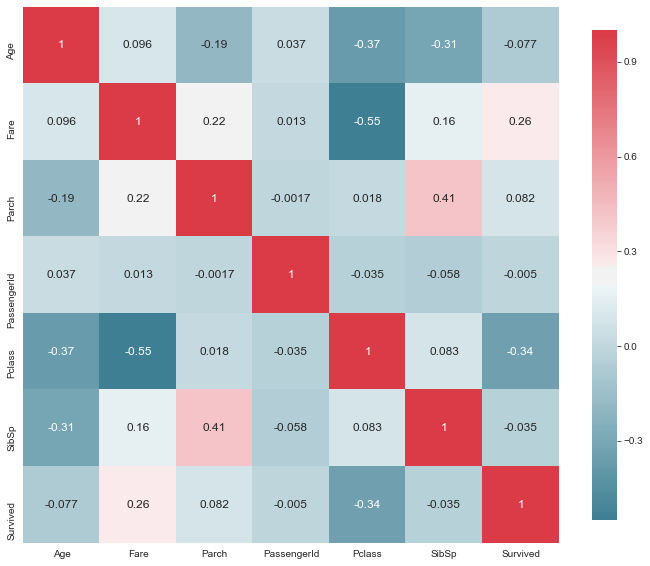

In [13]:
plot_correlation_map(df_train)

Correlations between Survived and Fare or Pclass are the highest. It's quite logic : Class 1 Passengers have been "protected" due to their social statut.
Apparently, it seems to have more impact on surviving rate than age.

Surviving rate is not really correlated to Parch and Sibsp, which deal with number of family's members.

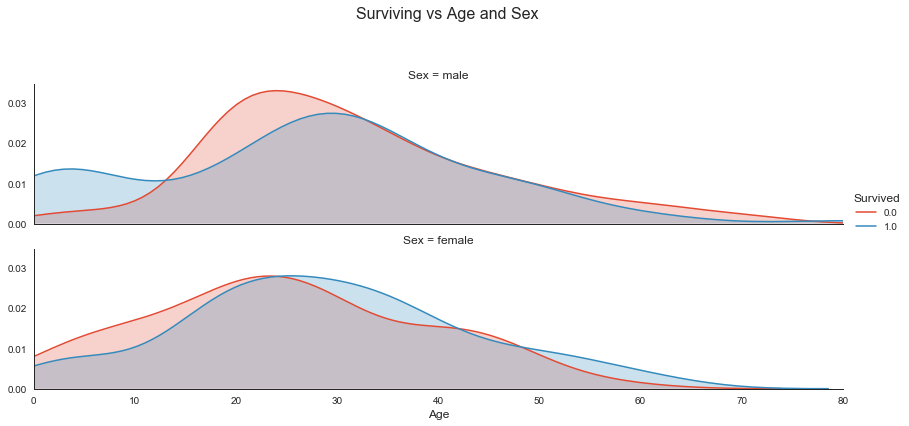

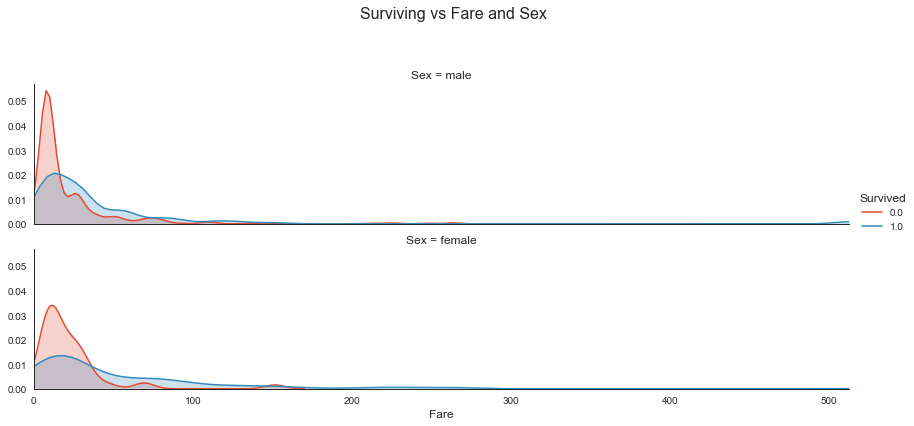

In [14]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( df_train , var = 'Age' , target = 'Survived' , row = 'Sex' ,
                  title = 'Surviving vs Age and Sex')

# Plot distributions of Fare of passangers who survived or did not survive
plot_distribution( df_train , var = 'Fare' , target = 'Survived' , row = 'Sex',
                  title = 'Surviving vs Fare and Sex')

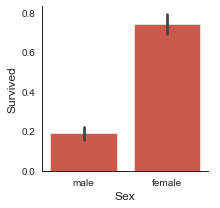

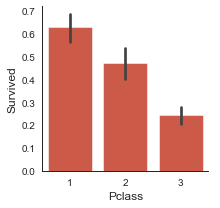

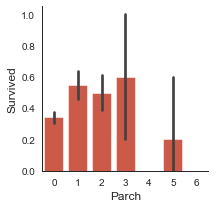

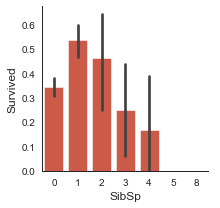

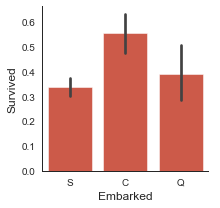

In [15]:
# Plot survival rate by Sex
plot_categories(df_train, cat = 'Sex', target = 'Survived' )

# Plot survival rate by Pclass
plot_categories( df_train , cat = 'Pclass' , target = 'Survived' )

# Plot survival rate by Parch
plot_categories( df_train , cat = 'Parch' , target = 'Survived' )

# Plot survival rate by SibSp
plot_categories( df_train , cat = 'SibSp' , target = 'Survived' )

# Plot survival rate by Embarked
plot_categories( df_train , cat = 'Embarked' , target = 'Survived' )

We can see as expected sex and class have major impact on surviving.

In [16]:
# Shape of training data (num_rows, num_columns)
print(df_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (df_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(891, 12)
Age         177
Cabin       687
Embarked      2
dtype: int64


In [17]:
# Shape of testing data (num_rows, num_columns)
print(df_test.shape)

# Number of missing values in each column of testing data
missing_val_count_by_column = (df_test.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(418, 12)
Age          86
Cabin       327
Fare          1
Survived    418
dtype: int64


## 5. Data Preparation
### 5.1 Dealing with numerical columns
We will filling blanks in columns 'Age' and 'Fare' with median.

In [18]:
full['Age'] = full['Age'].fillna(full.Age.median())
full['Fare'] = full['Fare'].fillna(full.Age.median())

In [19]:
full.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.503186,33.291434,0.385027,655.000000,2.294882,0.498854,0.383838
std,12.905241,51.739086,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,22.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,35.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


### 5.2 Dealing with categorical columns

I will use Label Encoder and One Hot Encoder on the categorical data but we can use "get_dummies" function to produce small dataframes we can concat then, before training.

In [20]:
# Replacing missing cabins and embarked with Unknown_ ...
full['Cabin'] = full.Cabin.fillna('Unknown_Cabin')
full['Embarked'] = full.Embarked.fillna('Unknown_Embarked')

In [21]:
# All categorical columns
object_cols = [col for col in full.columns if full[col].dtype == "object"]

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: full[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Sex', 2), ('Embarked', 4), ('Cabin', 187), ('Ticket', 929), ('Name', 1307)]

In [22]:
# Apply label encoder to column Sex
label_encoder = LabelEncoder()
full['Sex'] = label_encoder.fit_transform(full['Sex'])

In [23]:
# Apply one-hot encoder to each column with categorical data
categorical = ['Embarked']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_embarked = pd.DataFrame(OH_encoder.fit_transform(full[categorical]))

# One-hot encoding removed index; put it back
OH_embarked.index = full.index
OH_embarked

,0,1,2,3
0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0
6,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,0.0
9,1.0,0.0,0.0,0.0


I think get_dummies function is better for manual preparation : 
* you can have labels for new columns
* you prepare one dataframe per original column. If you prepare all your data like this, you just have to pick the ones you want for training.

Advantage of One Hot Encoder : you can put it in "pipeline". 
Have to check if you can do it with get_dummies.

In [24]:
full.drop(['Embarked'], axis=1, inplace=True)
full = pd.concat([full, OH_embarked], axis=1)
full

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,0,1,2,3
0,22.0,Unknown_Cabin,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,0.0,0.0,1.0,0.0
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,1.0,0.0,0.0,0.0
2,26.0,Unknown_Cabin,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,0.0,0.0,1.0,0.0
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,0.0,0.0,1.0,0.0
4,35.0,Unknown_Cabin,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,0.0,0.0,1.0,0.0
5,28.0,Unknown_Cabin,8.4583,"Moran, Mr. James",0,6,3,1,0,0.0,330877,0.0,1.0,0.0,0.0
6,54.0,E46,51.8625,"McCarthy, Mr. Timothy J",0,7,1,1,0,0.0,17463,0.0,0.0,1.0,0.0
7,2.0,Unknown_Cabin,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,1,3,0.0,349909,0.0,0.0,1.0,0.0
8,27.0,Unknown_Cabin,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,0,0,1.0,347742,0.0,0.0,1.0,0.0
9,14.0,Unknown_Cabin,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,0,1,1.0,237736,1.0,0.0,0.0,0.0


### 5.3 Training and validation datasets

In [25]:
# separate X and y (target : survived)
y = full.Survived[:891]
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
5      0.0
6      0.0
7      0.0
8      1.0
9      1.0
10     1.0
11     1.0
12     0.0
13     0.0
14     0.0
15     1.0
16     0.0
17     1.0
18     0.0
19     1.0
20     0.0
21     1.0
22     1.0
23     1.0
24     0.0
25     1.0
26     0.0
27     0.0
28     1.0
29     0.0
      ... 
861    0.0
862    1.0
863    0.0
864    0.0
865    1.0
866    1.0
867    0.0
868    0.0
869    1.0
870    0.0
871    1.0
872    0.0
873    0.0
874    1.0
875    1.0
876    0.0
877    0.0
878    0.0
879    1.0
880    1.0
881    0.0
882    0.0
883    0.0
884    0.0
885    0.0
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 891, dtype: float64

In [26]:
full.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'Survived', 'Parch', 'SibSp'], 
              axis=1, inplace=True)

In [27]:
X = full[:891]
X

,Age,Fare,Pclass,Sex,0,1,2,3
0,22.0,7.2500,3,1,0.0,0.0,1.0,0.0
1,38.0,71.2833,1,0,1.0,0.0,0.0,0.0
2,26.0,7.9250,3,0,0.0,0.0,1.0,0.0
3,35.0,53.1000,1,0,0.0,0.0,1.0,0.0
4,35.0,8.0500,3,1,0.0,0.0,1.0,0.0
5,28.0,8.4583,3,1,0.0,1.0,0.0,0.0
6,54.0,51.8625,1,1,0.0,0.0,1.0,0.0
7,2.0,21.0750,3,1,0.0,0.0,1.0,0.0
8,27.0,11.1333,3,0,0.0,0.0,1.0,0.0
9,14.0,30.0708,2,0,1.0,0.0,0.0,0.0


In [28]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [29]:
print(f"Shapes of X_train {X_train.shape} and y_train {y_train.shape}")
print(f"Shapes of X_valid {X_valid.shape} and y_valid {y_valid.shape}")

Shapes of X_train (712, 8) and y_train (712,)
Shapes of X_valid (179, 8) and y_valid (179,)


## 6. Modeling and training

In [30]:
model = RandomForestClassifier(random_state=0)

param_grid = {'n_estimators': range(100,1000,50)}

grid_search = GridSearchCV(model, param_grid , cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(f"best parameters from grid search: {grid_search.best_params_} accuracy : {grid_search.score(X_valid, y_valid):.3f}")

best parameters from grid search: {'n_estimators': 150} accuracy : 0.849


In [31]:
model = SVC(random_state=0)

param_grid = {
    'kernel': ['linear', 'rbf'], 
    'C': [1, 10],
    'gamma': [0.001, 0.0001]
    }

grid_search = GridSearchCV(model, param_grid , cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(f"best parameters from grid search: {grid_search.best_params_} accuracy : {grid_search.score(X_valid, y_valid):.3f}") 

best parameters from grid search: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'} accuracy : 0.788


In [32]:
model = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100,200,500,750,1000],
    'learning_rate': [0.05, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(model, param_grid , cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(f"best parameters from grid search: {grid_search.best_params_} accuracy : {grid_search.score(X_valid, y_valid):.3f}") 

best parameters from grid search: {'learning_rate': 0.05, 'n_estimators': 200} accuracy : 0.832


In [33]:
model = GaussianNB()

param_grid = {
    }

grid_search = GridSearchCV(model, param_grid , cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(f"best parameters from grid search: {grid_search.best_params_} accuracy : {grid_search.score(X_valid, y_valid):.3f}") 

best parameters from grid search: {} accuracy : 0.693


In [34]:
model = LogisticRegression(random_state=0)

param_grid = {
    'C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(model, param_grid, cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(f"best parameters from grid search: {grid_search.best_params_} accuracy : {grid_search.score(X_valid, y_valid):.3f}") 

best parameters from grid search: {'C': 1.0} accuracy : 0.793


In [35]:
model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': range(1,15,2)
}

grid_search = GridSearchCV(model, param_grid, cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(f"best parameters from grid search: {grid_search.best_params_} accuracy : {grid_search.score(X_valid, y_valid):.3f}") 

best parameters from grid search: {'n_neighbors': 11} accuracy : 0.743


In [36]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0)

param_grid = {
    'n_estimators': [100,200,500,750,1000],
    'learning_rate': [0.05, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(model, param_grid , cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(f"best parameters from grid search: {grid_search.best_params_} accuracy : {grid_search.score(X_valid, y_valid):.3f}")

[15:48:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:49:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:49:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

## 7. Submission

In [37]:

# Define and fit model
model = RandomForestClassifier(n_estimators=150, random_state=0)
model.fit(X_train, y_train)

# Predict target vector
X_test = full[891:]

In [38]:
X_test

,Age,Fare,Pclass,Sex,0,1,2,3
891,34.5,7.8292,3,1,0.0,1.0,0.0,0.0
892,47.0,7.0000,3,0,0.0,0.0,1.0,0.0
893,62.0,9.6875,2,1,0.0,1.0,0.0,0.0
894,27.0,8.6625,3,1,0.0,0.0,1.0,0.0
895,22.0,12.2875,3,0,0.0,0.0,1.0,0.0
896,14.0,9.2250,3,1,0.0,0.0,1.0,0.0
897,30.0,7.6292,3,0,0.0,1.0,0.0,0.0
898,26.0,29.0000,2,1,0.0,0.0,1.0,0.0
899,18.0,7.2292,3,0,1.0,0.0,0.0,0.0
900,21.0,24.1500,3,1,0.0,0.0,1.0,0.0


In [39]:
# Predict target vector
preds_test = model.predict(X_test)

In [40]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': df_test.PassengerId,
                       'Survived': preds_test})
output.to_csv('submission.csv', index=False)

In [41]:
output

,PassengerId,Survived
891,892,0.0
892,893,0.0
893,894,0.0
894,895,1.0
895,896,0.0
896,897,0.0
897,898,0.0
898,899,0.0
899,900,1.0
900,901,0.0
